In [142]:
import os
import numpy as np

import scipy
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
import lsst.afw.display as afw_display
import lsst.geom
afwDisplay.setDefaultBackend('matplotlib')
import matplotlib.ticker as plticker
import lsst.afw.cameraGeom.testUtils as testUtils
import lsst.afw.cameraGeom as cameraGeom
from lsst.obs.hsc import HscMapper as mapper
import lsst.daf.butler as dafButler
from skimage.filters import gaussian
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
import pandas as pd
from operator import itemgetter
from itertools import groupby
os.environ['PGPASSFILE'] = "/home/ebellm/.lsst/.pgpassfile" # unclear this 

import pandas as pd
import astropy.units as u
import astropy.coordinates as coord
import pyarrow.parquet as pq
import lsst.daf.butler as dafButler

### Examine DC2 Truth Table

See 
* https://lsstdesc-portal.nersc.gov/
* https://ui.adsabs.harvard.edu/abs/2021ApJS..253...31L/abstract 
* https://arxiv.org/pdf/2101.04855.pdf 

for details

In [107]:
!ls /project/shared/DC2/truth_parquet

truth_tract2723.parquet  truth_tract3445.parquet  truth_tract4230.parquet
truth_tract2724.parquet  truth_tract3446.parquet  truth_tract4231.parquet
truth_tract2725.parquet  truth_tract3447.parquet  truth_tract4232.parquet
truth_tract2726.parquet  truth_tract3448.parquet  truth_tract4233.parquet
truth_tract2727.parquet  truth_tract3449.parquet  truth_tract4234.parquet
truth_tract2728.parquet  truth_tract3450.parquet  truth_tract4235.parquet
truth_tract2729.parquet  truth_tract3451.parquet  truth_tract4236.parquet
truth_tract2730.parquet  truth_tract3452.parquet  truth_tract4429.parquet
truth_tract2731.parquet  truth_tract3453.parquet  truth_tract4430.parquet
truth_tract2732.parquet  truth_tract3454.parquet  truth_tract4431.parquet
truth_tract2733.parquet  truth_tract3631.parquet  truth_tract4432.parquet
truth_tract2734.parquet  truth_tract3632.parquet  truth_tract4433.parquet
truth_tract2735.parquet  truth_tract3633.parquet  truth_tract4434.parquet
truth_tract2896.parquet  truth_tract36

In [4]:
truth = pq.read_pandas('/project/shared/DC2/truth_parquet/truth_tract3828.parquet').to_pandas()

In [5]:
len(truth)

4645755

In [6]:
truth.head()

,id,host_galaxy,ra,dec,redshift,is_variable,is_pointsource,flux_u,flux_g,flux_r,...,patch,truth_type,cosmodc2_hp,cosmodc2_id,mag_r,match_objectId,match_sep,is_good_match,is_nearest_neighbor,is_unique_truth_entry
0,7816513885,-1,57.503538,-37.189842,1.270010,0,0,246.984558,234.669754,214.219315,...,"0,0",1,9812,7816513885,25.572853,16835722044507628,0.049484,True,True,True
1,7812675090,-1,57.451876,-37.189982,0.344580,0,0,31.958035,60.569202,131.726593,...,"0,0",1,9812,7812675090,26.100817,16835722044507640,0.234430,True,True,True
2,7814647934,-1,57.506052,-37.189499,0.990622,0,0,65.868942,80.165848,122.161423,...,"0,0",1,9812,7814647934,26.182667,16835722044507645,0.215764,True,True,True
3,7814197393,-1,57.529435,-37.189048,0.892836,0,0,66.701424,88.351448,162.388611,...,"0,0",1,9812,7814197393,25.873611,16835722044507650,0.032703,True,True,True
4,7813507782,-1,57.407629,-37.189873,0.697208,0,0,17.108637,28.560108,67.255020,...,"0,0",1,9812,7813507782,26.830688,16835722044507655,0.208699,False,True,True


In [7]:
truth.columns

Index(['id', 'host_galaxy', 'ra', 'dec', 'redshift', 'is_variable',
       'is_pointsource', 'flux_u', 'flux_g', 'flux_r', 'flux_i', 'flux_z',
       'flux_y', 'flux_u_noMW', 'flux_g_noMW', 'flux_r_noMW', 'flux_i_noMW',
       'flux_z_noMW', 'flux_y_noMW', 'tract', 'patch', 'truth_type',
       'cosmodc2_hp', 'cosmodc2_id', 'mag_r', 'match_objectId', 'match_sep',
       'is_good_match', 'is_nearest_neighbor', 'is_unique_truth_entry'],
      dtype='object')

In [8]:
truth.loc[~truth['is_unique_truth_entry'],'id']

4690        7825439919
4691        7825439919
4692        7817065275
4693       30830360449
4694       30830360449
              ...     
1107869     6827612401
1107916     6819858142
1107957     6814015831
1108019     6825945915
1108063     6819222223
Name: id, Length: 7585, dtype: object

In [9]:
truth.loc[truth['id']==7825439919]

,id,host_galaxy,ra,dec,redshift,is_variable,is_pointsource,flux_u,flux_g,flux_r,...,patch,truth_type,cosmodc2_hp,cosmodc2_id,mag_r,match_objectId,match_sep,is_good_match,is_nearest_neighbor,is_unique_truth_entry


In [10]:
truth.loc[[4690,4691]]

,id,host_galaxy,ra,dec,redshift,is_variable,is_pointsource,flux_u,flux_g,flux_r,...,patch,truth_type,cosmodc2_hp,cosmodc2_id,mag_r,match_objectId,match_sep,is_good_match,is_nearest_neighbor,is_unique_truth_entry
4690,7825439919,-1,57.491971,-37.186337,1.998428,0,0,14.737312,15.066756,13.18913,...,"0,0",1,9812,7825439919,28.599461,16835722044535449,1.462159,False,True,False
4691,7825439919,-1,57.491971,-37.186337,1.998428,0,0,14.737312,15.066756,13.18913,...,"0,0",1,9812,7825439919,28.599461,16835722044535450,0.896426,False,True,False


In [11]:
truth.loc[(truth.is_variable == True) & (truth.is_pointsource == False) ]

,id,host_galaxy,ra,dec,redshift,is_variable,is_pointsource,flux_u,flux_g,flux_r,...,patch,truth_type,cosmodc2_hp,cosmodc2_id,mag_r,match_objectId,match_sep,is_good_match,is_nearest_neighbor,is_unique_truth_entry


So it looks like all variables are point sources.

In [12]:
truth.loc[(truth.is_variable == True),'truth_type'].unique()

array([2, 3])

per https://arxiv.org/pdf/2101.04855.pdf truth types 2 are stars and 3 are SNe

In [13]:
truthsc = coord.SkyCoord(truth.ra,truth.dec,unit='deg')

### Load DM-reprocessed DIASource catalogs

swiped from https://github.com/yalsayyad/dm_notebooks/blob/u/yusra/first_dc2/examples/Gen3-DiaSourceCensus-DC2-med-test.ipynb

In [14]:
COLLECTION = '2.2i/runs/test-med-1/w_2021_24/DM-30674'
#COLLECTION = 'u/ebellm/PREOPS-559'
butler = dafButler.Butler('/repo/dc2', collections=COLLECTION)

In [15]:
dataIds =  butler.registry.queryDataIds(['band', 'instrument', 'detector', 'physical_filter', 'visit_system', 'visit'] , datasets="goodSeeingDiff_diaSrcTable", 
                                       collections=COLLECTION, where="instrument='LSSTCam-imSim'")

In [16]:
tables = []
for dataId in dataIds:
    tables.append(butler.get('goodSeeingDiff_diaSrcTable', dataId=dataId))

df = pd.concat(tables)

In [17]:
len(df)

416672

In [18]:
config = TransformDiaSourceCatalogConfig()
unpacker = UnpackApdbFlags(config.flagMap, 'DiaSource')
flag_values = unpacker.unpack(df['flags'], 'flags')
flag_names = list(flag_values.dtype.names)

flags = pd.DataFrame(flag_values, index=df.index)
df = pd.concat([df, flags], axis=1)
print("List of available flags: ", flags.columns)


List of available flags:  Index(['base_PixelFlags_flag', 'base_PixelFlags_flag_offimage',
       'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_interpolated',
       'base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_cr',
       'base_PixelFlags_flag_bad', 'base_PixelFlags_flag_suspect',
       'base_PixelFlags_flag_interpolatedCenter',
       'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_crCenter',
       'base_PixelFlags_flag_suspectCenter', 'slot_Centroid_flag',
       'slot_Centroid_pos_flag', 'slot_Centroid_neg_flag', 'slot_ApFlux_flag',
       'slot_ApFlux_flag_apertureTruncated', 'slot_PsfFlux_flag',
       'slot_PsfFlux_flag_noGoodPixels', 'slot_PsfFlux_flag_edge',
       'ip_diffim_forced_PsfFlux_flag',
       'ip_diffim_forced_PsfFlux_flag_noGoodPixels',
       'ip_diffim_forced_PsfFlux_flag_edge', 'slot_Shape_flag',
       'slot_Shape_flag_unweightedBad', 'slot_Shape_flag_unweighted',
       'slot_Shape_flag_shift', 'slot_Shape_flag_maxIter',
       

In [19]:
instrumentDataId = butler.registry.expandDataId(instrument='LSSTCam-imSim')
packer = butler.registry.dimensions.makePacker("visit_detector", instrumentDataId)
df['visit'] = df.ccdVisitId.apply(lambda x: packer.unpack(x)['visit'])
df['detector'] = df.ccdVisitId.apply(lambda x: packer.unpack(x)['detector'])

In [20]:
# create some derived columns

pixToArcseconds = 0.2
PIXEL_SCALE = 0.2
SIGMA2FWHM = 2*np.sqrt(2*np.log(2))
traceRadius = np.sqrt(0.5) * np.sqrt(df.ixxPSF + df.iyyPSF)
df['seeing'] = SIGMA2FWHM * traceRadius

bbox = butler.get('goodSeeingDiff_differenceExp.bbox', visit = 471987 , detector=5)
wcs = butler.get('goodSeeingDiff_differenceExp.wcs', visit = 471987 , detector=5)
APPROX_CCD_AREA = bbox.getArea()*wcs.getPixelScale().asDegrees()**2

In [21]:
# get Focal Plane Coordinates (is there a faster way to do this?)
camera = butler.get('camera', instrument='LSSTCam-imSim')

def ccd2focalPlane(x, y, ccd):
    cc = int(ccd)
    det = camera[cc]
    point = det.transform(lsst.geom.Point2D(x, y), cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE)
    return point[0], point[1]

vecCcd2FP =  np.vectorize(ccd2focalPlane)
focal_plane = vecCcd2FP(df['x'].values.astype(float), df['y'].values.astype(float), df['detector'].values.astype(int))
df['xFP'] = focal_plane[0]
df['yFP'] = focal_plane[1]

In [22]:
pixelFlagNames = [
       'base_PixelFlags_flag_offimage',
       'base_PixelFlags_flag_edge',
       'base_PixelFlags_flag_interpolated',
       'base_PixelFlags_flag_saturated',
       'base_PixelFlags_flag_cr',
       'base_PixelFlags_flag_bad',
       'base_PixelFlags_flag_suspect',
       'base_PixelFlags_flag_interpolatedCenter',
       'base_PixelFlags_flag_saturatedCenter',
       'base_PixelFlags_flag_crCenter',
       'base_PixelFlags_flag_suspectCenter']

centroidFlagNames = [
       'slot_Centroid_flag',
       'slot_Centroid_pos_flag',
       'slot_Centroid_neg_flag',]
    
fluxFlagNames = [
       'slot_ApFlux_flag',
       'slot_ApFlux_flag_apertureTruncated',
       'slot_PsfFlux_flag',
       'slot_PsfFlux_flag_noGoodPixels',
       'slot_PsfFlux_flag_edge',
       'ip_diffim_forced_PsfFlux_flag',
       'ip_diffim_forced_PsfFlux_flag_noGoodPixels',
       'ip_diffim_forced_PsfFlux_flag_edge']

shapeFlagNames = [
       'slot_Shape_flag',
       'slot_Shape_flag_unweightedBad',
       'slot_Shape_flag_unweighted',
       'slot_Shape_flag_shift',
       'slot_Shape_flag_maxIter',
       'slot_Shape_flag_psf']

In [23]:
df.columns

Index(['diaSourceId', 'ccdVisitId', 'filterName', 'diaObjectId',
       'parentDiaSourceId', 'midPointTai', 'pixelId', 'bboxSize', 'flags',
       'ra', 'decl', 'x', 'y', 'xErr', 'yErr', 'apFlux', 'apFluxErr', 'snr',
       'psFlux', 'psFluxErr', 'dipMeanFlux', 'dipMeanFluxErr', 'dipFluxDiff',
       'dipFluxDiffErr', 'dipLength', 'dipAngle', 'dipChi2', 'isDipole',
       'totFlux', 'totFluxErr', 'ixx', 'iyy', 'ixy', 'ixxPSF', 'iyyPSF',
       'ixyPSF', 'base_PixelFlags_flag', 'base_PixelFlags_flag_offimage',
       'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_interpolated',
       'base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_cr',
       'base_PixelFlags_flag_bad', 'base_PixelFlags_flag_suspect',
       'base_PixelFlags_flag_interpolatedCenter',
       'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_crCenter',
       'base_PixelFlags_flag_suspectCenter', 'slot_Centroid_flag',
       'slot_Centroid_pos_flag', 'slot_Centroid_neg_flag', 'slot_ApFlux_flag',
 

In [24]:
len(df)

416672

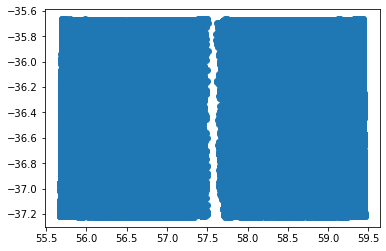

In [25]:
plt.scatter(df.ra,df.decl)

In [26]:
diaSourcesc = coord.SkyCoord(df.ra,df.decl,unit='deg')

### check on DIASource associations

In [27]:


dataIds =  butler.registry.queryDataIds(['skymap','tract','patch'] , datasets="goodSeeingDiff_assocDiaSrcTable", 
                                       collections=COLLECTION, where="instrument='LSSTCam-imSim'")

In [28]:
set([x['tract'] for x in dataIds])

{3828}

In [29]:
tables = []
for dataId in dataIds:
    tables.append(butler.get('goodSeeingDiff_assocDiaSrcTable', dataId=dataId))

dfass = pd.concat(tables)

In [30]:
len(dfass)

37888

so a lot fewer DiaSources, due to upstream pipeline failures.  I can use the "raw" DiaSources above to compare to the truth table, although it will be more annoying...

In [31]:
dfass.head()

,ccdVisitId,diaSourceId,filterName,diaObjectId,parentDiaSourceId,midPointTai,pixelId,bboxSize,flags,ra,...,dipChi2,isDipole,totFlux,totFluxErr,ixx,iyy,ixy,ixxPSF,iyyPSF,ixyPSF
0,183818013,98686544281338023,g,3300135772258041994,0,59823.311143,0,129,75498268,56.171273,...,NaN,False,1.987825e+05,395.947396,10.062371,4.054994,0.312510,0.237825,0.003751,0.003751
1,183818013,98686544281338025,g,3300135772258041926,0,59823.311143,0,47,25165824,56.230046,...,1518.554526,True,2.907464e+05,527.708239,NaN,NaN,NaN,0.237828,0.003751,0.003751
2,183818013,98686544281338027,g,3300135772258042168,0,59823.311143,0,17,25165824,56.219070,...,NaN,False,-2.108749e+02,103.807468,NaN,NaN,NaN,0.237829,0.003751,0.003751
3,183818013,98686544281338029,g,3300135772258042140,0,59823.311143,0,32,25166092,56.156852,...,NaN,False,-1.672217e+02,104.428236,NaN,NaN,NaN,0.237826,0.003751,0.003751
4,183818013,98686544281338030,g,3300135772258041886,0,59823.311143,0,61,41943836,56.207051,...,NaN,False,2.285673e+06,1448.221200,0.228815,0.211231,-0.000957,0.237833,0.003751,0.003751


In [32]:
dfass.columns

Index(['ccdVisitId', 'diaSourceId', 'filterName', 'diaObjectId',
       'parentDiaSourceId', 'midPointTai', 'pixelId', 'bboxSize', 'flags',
       'ra', 'decl', 'x', 'y', 'xErr', 'yErr', 'apFlux', 'apFluxErr', 'snr',
       'psFlux', 'psFluxErr', 'dipMeanFlux', 'dipMeanFluxErr', 'dipFluxDiff',
       'dipFluxDiffErr', 'dipLength', 'dipAngle', 'dipChi2', 'isDipole',
       'totFlux', 'totFluxErr', 'ixx', 'iyy', 'ixy', 'ixxPSF', 'iyyPSF',
       'ixyPSF'],
      dtype='object')

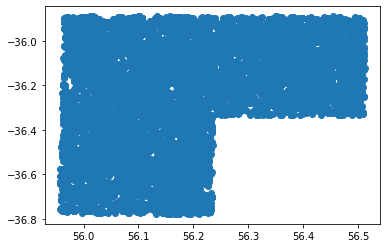

In [33]:
#plt.scatter(df.ra,df.decl)
plt.scatter(dfass.ra,dfass.decl)

These are highly incomplete due to pipeline failures in this reprocessing

### DIAObjects

In [34]:


dataIds =  butler.registry.queryDataIds(['skymap','tract','patch'] , datasets="goodSeeingDiff_diaObjTable", 
                                       collections=COLLECTION, where="instrument='LSSTCam-imSim'")

In [35]:
tables = []
for dataId in dataIds:
    tables.append(butler.get('goodSeeingDiff_diaObjTable', dataId=dataId))

dfo = pd.concat(tables)

In [36]:
len(dfo)

10778

In [37]:
dfo.head()

,diaObjectId,ra,decl,nDiaSources
0,3300135772258041857,55.958846,-36.715960,4
1,3300135772258041858,56.000846,-36.733261,1
2,3300135772258041859,55.966733,-36.747807,54
3,3300135772258041860,56.005147,-36.753971,33
4,3300135772258041861,56.093826,-36.556317,1


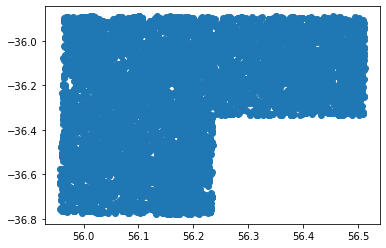

In [38]:
plt.scatter(dfo.ra,dfo.decl)

Similar to the associated DIASources, these are highly incomplete.

### Perform crossmatch

We will crossmatch the raw DIASources to the truth table as the associated DIASources are incomplete.

In [39]:
MATCH_RADIUS_ARCSEC = 1.0

In [40]:
idx, d2d, d3d = diaSourcesc.match_to_catalog_sky(truthsc)

In [41]:
idx

array([2072686, 2206113, 2072686, ..., 2043969, 1781747, 1506716])

In [42]:
truth.iloc[idx]['id']

2072686    6883181858
2206113    6883487998
2072686    6883181858
1818886    6878683571
2202652    6883450817
              ...    
2043969    6887700131
1620968    6878506904
2043969    6887700131
1781747    6878105501
1506716    6876129758
Name: id, Length: 416672, dtype: object

In [43]:
# get back into pandas.  
df['truth_xmatch_dist_arcsec'] = d2d.to_value(u.arcsecond)
# Let's include all the matches, for reference
df['truth_xmatch_id_all'] = pd.Series(truth.iloc[idx]['id'].values, index=df.index)
# now make a column that only has the matches with radius.
df.loc[df['truth_xmatch_dist_arcsec'] <= MATCH_RADIUS_ARCSEC, 'truth_xmatch_id'] = df.loc[df['truth_xmatch_dist_arcsec'] <= MATCH_RADIUS_ARCSEC, 'truth_xmatch_id_all']

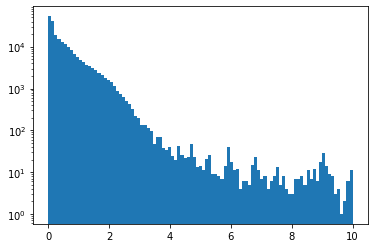

In [44]:
_ = plt.hist(df['truth_xmatch_dist_arcsec'],bins=np.linspace(0,10,100))
plt.gca().set_yscale('log')

note that running this seems to require a "large" instance

In [45]:
dfm = pd.merge(truth,df,left_on='id',right_on='truth_xmatch_id',how='outer')

In [46]:
dfm

,id,host_galaxy,ra_x,dec,redshift,is_variable,is_pointsource,flux_u,flux_g,flux_r,...,slot_Shape_flag_maxIter,slot_Shape_flag_psf,visit,detector,seeing,xFP,yFP,truth_xmatch_dist_arcsec,truth_xmatch_id_all,truth_xmatch_id
0,7816513885,-1.0,57.503538,-37.189842,1.270010,0.0,0.0,246.984558,234.669754,214.219315,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7812675090,-1.0,57.451876,-37.189982,0.344580,0.0,0.0,31.958035,60.569202,131.726593,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7814647934,-1.0,57.506052,-37.189499,0.990622,0.0,0.0,65.868942,80.165848,122.161423,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7814197393,-1.0,57.529435,-37.189048,0.892836,0.0,0.0,66.701424,88.351448,162.388611,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7813507782,-1.0,57.407629,-37.189873,0.697208,0.0,0.0,17.108637,28.560108,67.255020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5086070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,496989.0,188.0,0.599789,180.056313,314.882361,2872.473468,6887700131,NaN
5086071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,496989.0,188.0,0.599744,189.139590,315.104912,2983.971227,6878506904,NaN
5086072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,496989.0,188.0,0.599795,177.325662,315.626277,2852.117651,6887700131,NaN
5086073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,496989.0,188.0,0.599837,168.135417,315.661987,2743.393065,6878105501,NaN


In [97]:
dfm.columns.to_list()

['id',
 'host_galaxy',
 'ra_x',
 'dec',
 'redshift',
 'is_variable',
 'is_pointsource',
 'flux_u',
 'flux_g',
 'flux_r',
 'flux_i',
 'flux_z',
 'flux_y',
 'flux_u_noMW',
 'flux_g_noMW',
 'flux_r_noMW',
 'flux_i_noMW',
 'flux_z_noMW',
 'flux_y_noMW',
 'tract',
 'patch',
 'truth_type',
 'cosmodc2_hp',
 'cosmodc2_id',
 'mag_r',
 'match_objectId',
 'match_sep',
 'is_good_match',
 'is_nearest_neighbor',
 'is_unique_truth_entry',
 'diaSourceId',
 'ccdVisitId',
 'filterName',
 'diaObjectId',
 'parentDiaSourceId',
 'midPointTai',
 'pixelId',
 'bboxSize',
 'flags',
 'ra_y',
 'decl',
 'x',
 'y',
 'xErr',
 'yErr',
 'apFlux',
 'apFluxErr',
 'snr',
 'psFlux',
 'psFluxErr',
 'dipMeanFlux',
 'dipMeanFluxErr',
 'dipFluxDiff',
 'dipFluxDiffErr',
 'dipLength',
 'dipAngle',
 'dipChi2',
 'isDipole',
 'totFlux',
 'totFluxErr',
 'ixx',
 'iyy',
 'ixy',
 'ixxPSF',
 'iyyPSF',
 'ixyPSF',
 'base_PixelFlags_flag',
 'base_PixelFlags_flag_offimage',
 'base_PixelFlags_flag_edge',
 'base_PixelFlags_flag_interpolated'

### Evaluate confusion matrix

In [48]:
wmatched = (dfm['truth_xmatch_dist_arcsec'] <= MATCH_RADIUS_ARCSEC)

In [49]:
len(dfm)

5086075

In [50]:
np.sum(wmatched) + np.sum(~wmatched)

5086075

In [51]:
# true positives
wtp = wmatched & (dfm['is_variable'] == 1) # have to use explicit equality since is_variable can be NaN when there is no truth counterpart
ntp = np.sum(wtp)
dfm.loc[wtp,'confusion_label'] = 'True Positive'
print(ntp)

196016


In [52]:
# true negatives 
wtn = ~wmatched & (dfm['is_variable'] == 0)
ntn = np.sum(wtn)
dfm.loc[wtn,'confusion_label'] = 'True Negative'

print(ntn)

4590911


In [53]:
# false positives (either a match to a non-variable source, or a DIASource with no truth table counterpart)
wfp = (wmatched & (dfm['is_variable'] == 0)) | (dfm['id'].isnull())
nfp = np.sum(wfp)
dfm.loc[wfp,'confusion_label'] = 'False Positive'

print(nfp)

275936


In [54]:
# false negatives (maybe!  depends how bright the variability is) 
wfn = ~wmatched & (dfm['is_variable'] == 1)
nfn = np.sum(wfn)
dfm.loc[wfn,'confusion_label'] = 'False Negative'

print(nfn)

23212


Since we have truth labels and "predictions" (whether or not we actually detected a DIASource) we can use the scikit-learn tooling to make a confusion matrix.  Our truth labels are true if there is a variable source in the simulation and false otherwise, and our prediction for that row is true if there is a matched DIASource and false otherwise.

In [55]:
# now let's put this in sklearn language
y_true = dfm['is_variable'] == 1.0
y_pred = wmatched

In [56]:
len(dfm) == (ntp + ntn + nfp + nfn)

True

In [57]:
(ntp + ntn + nfp + nfn)

5086075

In [58]:
len(truth) == len(dfm)

False

these are not the same because we have false positive DIASources that don't have truth entries

In [59]:
np.sum(dfm['id'].isna())

232849

In [60]:
len(truth) + np.sum(dfm['id'].isna())== len(dfm)

False

In [61]:
len(truth)

4645755

In [62]:
len(dfm)

5086075

In [63]:
len(truth) + np.sum(dfm['id'].isna())

4878604

(maybe this is multiple DIASources to the same truth entry?)

In [64]:
len(dfm['id'].unique())

4638171

In [65]:
len(truth['id'].unique())

4638170

the off by one is pretty annoying...  but this seems to confirm that duplicate truth-match entries is the issue.

In [66]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [67]:
sns.set_context('talk')

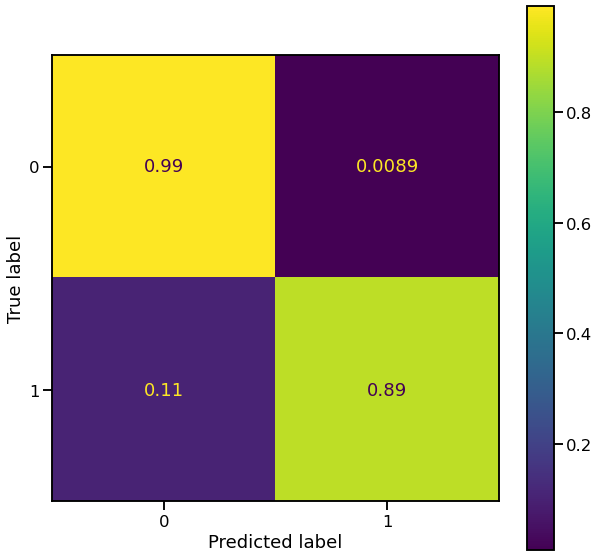

In [68]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cm = confusion_matrix(y_true, y_pred, normalize='true')#, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#,
                               #display_labels=clf.classes_)
disp.plot(ax=ax) 

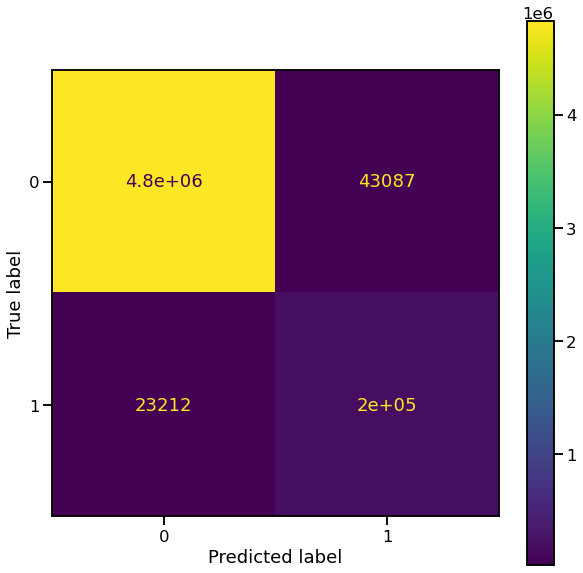

In [135]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cm = confusion_matrix(y_true, y_pred)#, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#,
                               #display_labels=clf.classes_)
disp.plot(ax=ax) 

In [136]:
cm

array([[4823760,   43087],
       [  23212,  196016]])

In [138]:
cm[1,:]

array([ 23212, 196016])

In [139]:
cm[:,1]

array([ 43087, 196016])

In [141]:
completeness = cm[1,1]/np.sum(cm[1,:])
purity = cm[1,1]/np.sum(cm[:,1])
print(completeness, purity)

0.8941193643147773 0.8197973258386553


### Plots of the samples

In [98]:
dfm.columns.tolist()

['id',
 'host_galaxy',
 'ra_x',
 'dec',
 'redshift',
 'is_variable',
 'is_pointsource',
 'flux_u',
 'flux_g',
 'flux_r',
 'flux_i',
 'flux_z',
 'flux_y',
 'flux_u_noMW',
 'flux_g_noMW',
 'flux_r_noMW',
 'flux_i_noMW',
 'flux_z_noMW',
 'flux_y_noMW',
 'tract',
 'patch',
 'truth_type',
 'cosmodc2_hp',
 'cosmodc2_id',
 'mag_r',
 'match_objectId',
 'match_sep',
 'is_good_match',
 'is_nearest_neighbor',
 'is_unique_truth_entry',
 'diaSourceId',
 'ccdVisitId',
 'filterName',
 'diaObjectId',
 'parentDiaSourceId',
 'midPointTai',
 'pixelId',
 'bboxSize',
 'flags',
 'ra_y',
 'decl',
 'x',
 'y',
 'xErr',
 'yErr',
 'apFlux',
 'apFluxErr',
 'snr',
 'psFlux',
 'psFluxErr',
 'dipMeanFlux',
 'dipMeanFluxErr',
 'dipFluxDiff',
 'dipFluxDiffErr',
 'dipLength',
 'dipAngle',
 'dipChi2',
 'isDipole',
 'totFlux',
 'totFluxErr',
 'ixx',
 'iyy',
 'ixy',
 'ixxPSF',
 'iyyPSF',
 'ixyPSF',
 'base_PixelFlags_flag',
 'base_PixelFlags_flag_offimage',
 'base_PixelFlags_flag_edge',
 'base_PixelFlags_flag_interpolated'

In [70]:
#sns.displot(dfm,x='flux_r',hue='confusion_label') # this killed the kernel

Text(0, 0.5, 'Number of Sources')

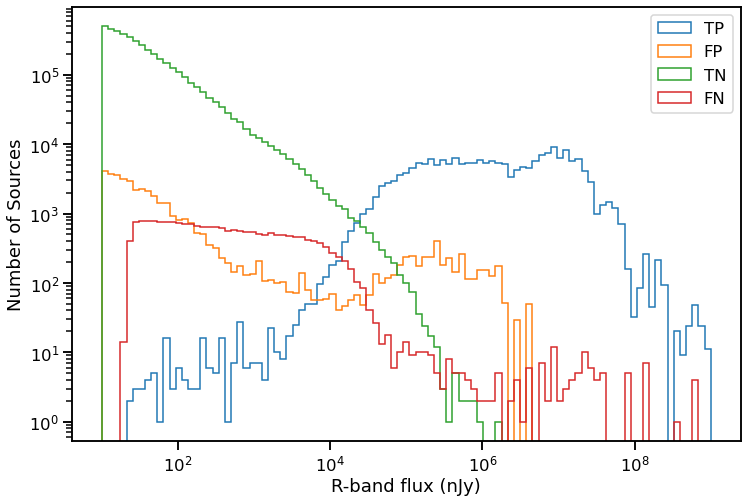

In [84]:
fig = plt.figure(figsize=(12,8))
bins = np.logspace(1,9,100)
_ = plt.hist(dfm.loc[wtp,'flux_r'],bins=bins, label='TP', histtype='step')
_ = plt.hist(dfm.loc[wfp,'flux_r'],bins=bins, label='FP', histtype='step')
_ = plt.hist(dfm.loc[wtn,'flux_r'],bins=bins, label='TN', histtype='step')
_ = plt.hist(dfm.loc[wfn,'flux_r'],bins=bins, label='FN', histtype='step')
plt.legend()
plt.xscale('log')
plt.yscale('log')

plt.xlabel('R-band flux (nJy)')
plt.ylabel('Number of Sources')

In [86]:
dfm['snr'].max()

4843.039781483016

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6731: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6732: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6731: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6732: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


Text(0, 0.5, 'Number of Sources')

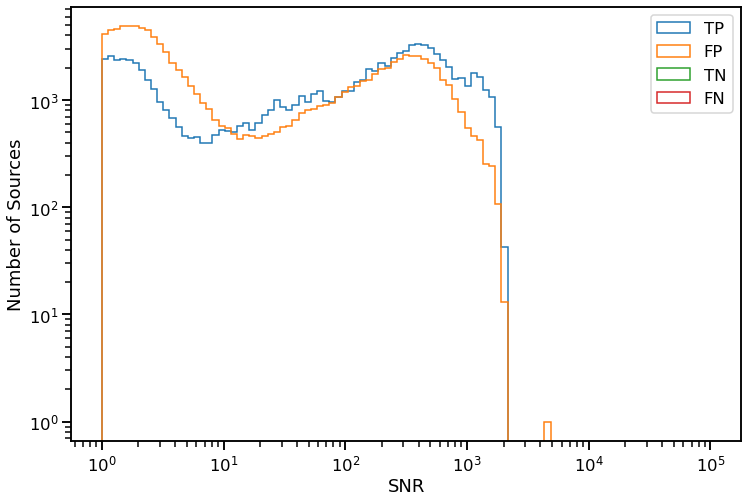

In [91]:
fig = plt.figure(figsize=(12,8))
bins = np.logspace(0,5,100)
_ = plt.hist(dfm.loc[wtp,'snr'],bins=bins, label='TP', histtype='step')
_ = plt.hist(dfm.loc[wfp,'snr'],bins=bins, label='FP', histtype='step')
_ = plt.hist(dfm.loc[wtn,'snr'],bins=bins, label='TN', histtype='step')
_ = plt.hist(dfm.loc[wfn,'snr'],bins=bins, label='FN', histtype='step')
plt.legend()
plt.xscale('log')
plt.yscale('log')

plt.xlabel('SNR')
plt.ylabel('Number of Sources')

In [96]:
grp = dfm.groupby('confusion_label')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(grp.agg(np.nanmedian).T)

confusion_label,False Negative,False Positive,True Negative,True Positive
host_galaxy,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
ra_x,5.668683e+01,5.650471e+01,5.665788e+01,5.645399e+01
dec,-3.644404e+01,-3.644357e+01,-3.644379e+01,-3.643551e+01
redshift,0.000000e+00,1.269958e+00,1.382919e+00,0.000000e+00
is_variable,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
is_pointsource,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
flux_u,9.403290e+00,1.734447e+01,1.446320e+01,2.653226e+05
flux_g,7.753836e+01,2.182268e+01,1.864100e+01,8.776379e+05
flux_r,2.241487e+02,2.781174e+01,2.329398e+01,1.443046e+06
flux_i,5.311954e+02,3.765845e+01,3.050244e+01,1.775023e+06


why don't the flags show up in the above??

In [126]:
print(f'{"":<40}\tFP  \tTP')
for col in dfm.columns:
    if 'flag' in col and col != 'flags':
        print(f'{col:<40}\t{dfm.loc[wfp,col].sum()/np.sum(wfp)*100:3.1f}%\t{dfm.loc[wtp,col].sum()/np.sum(wtp)*100:3.1f}%')

                                        	FP  	TP
base_PixelFlags_flag                    	0.0%	0.0%
base_PixelFlags_flag_offimage           	0.0%	0.0%
base_PixelFlags_flag_edge               	24.0%	43.4%
base_PixelFlags_flag_interpolated       	38.3%	45.0%
base_PixelFlags_flag_saturated          	40.0%	49.4%
base_PixelFlags_flag_cr                 	1.3%	1.5%
base_PixelFlags_flag_bad                	0.0%	0.0%
base_PixelFlags_flag_suspect            	0.0%	0.0%
base_PixelFlags_flag_interpolatedCenter 	37.9%	44.7%
base_PixelFlags_flag_saturatedCenter    	39.8%	49.3%
base_PixelFlags_flag_crCenter           	0.5%	0.2%
base_PixelFlags_flag_suspectCenter      	0.0%	0.0%
slot_Centroid_flag                      	0.0%	0.0%
slot_Centroid_pos_flag                  	0.0%	0.0%
slot_Centroid_neg_flag                  	0.0%	0.0%
slot_ApFlux_flag                        	0.0%	0.0%
slot_ApFlux_flag_apertureTruncated      	0.0%	0.0%
slot_PsfFlux_flag                       	3.4%	1.9%
slot_PsfFlux_flag_noGoo

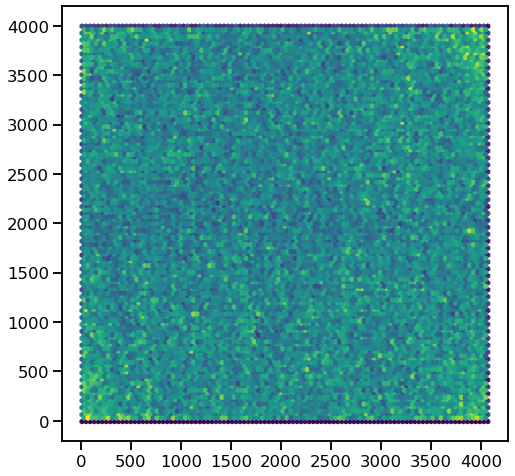

In [134]:
plt.figure(figsize=(8,8))
plt.hexbin(dfm.loc[wfp,'x'],dfm.loc[wfp,'y'])